# Implementation of Variational AutoEncoder (VAE)

     VAE from "Auto-Encoding Variational Bayes" (2014, D.P. Kingma et. al.)
    
     Kernel-author: Jackson Kang @ Deep-learning Lab. (Handong Global University, S.Korea)
     
     Author-email:  mskang@handong.edu

     python and pytorch version: python=3.7, pytorch=1.3.1

本示例程序是个生成式(Generative)任务，VAE是个具有“生成能力”的模型框架。

In [3]:
import torch
import torch.nn as nn   # nn = Neural Network，创建神经网络的工具

import numpy as np      # 处理张量的“始祖”级库，Torch横行后现在一般用在库之间数据交流部分。

from tqdm import tqdm   # 进度可视化
from torchvision.utils import save_image, make_grid # 可视化工具

In [4]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 100    # for循环里面一次处理batch_size个samples

x_dim  = 784        # 输入和输出图片维度，784=28*28
hidden_dim = 400    # 中间层维度, Encoder: x_dim -> hidden_dim -> latent_dim
latent_dim = 200    # VAE Encode输出和Decode输入的隐空间维度

lr = 1e-3           # Learning-rate 学习率

epochs = 30         # 训练轮数

###    Step 1. Load (or download) Dataset

In [5]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

# MNIST数据集：http://yann.lecun.com/exdb/mnist/ , 6万+1万
# CelebA数据集：https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html , 20万图片，1万标签
# ImageNet数据集: https://www.image-net.org/ , 1千400万
train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)       # 训练用样本，6w
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)      # 测试用样本，1w

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

### Step 2. Define our model: Variational AutoEncoder (VAE)

In [6]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

# 编码器：把输入降维到Latent
# 从nn.Module派生可以让有Learnable Parameters的成员变量保存到checkpoint里面。
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)    # FC=Fully Connected Layer，示例没有使用卷积。
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)  # 用了两层全连接层。
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)  # 激活函数
        
        self.training = True
        
    def forward(self, x):
        # nn.Linear: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        # ReLU: https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html
        # LeakyReLU: https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html
        # 激活函数没有可训练参数，所以两层可以共用 
        h_       = self.LeakyReLU(self.FC_input(x))     # y1=w1*x1 + b1 (忽略了LeakyReLU)
        h_       = self.LeakyReLU(self.FC_input2(h_))   # y2=w2*y1 + b2
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var # 这就是输出的Latent，均值和方差

In [7]:
# 解码器：接受Latent，升维到输出维。
# 解码器把编码器“倒”过来执行了一遍。
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        # nn.Sigmoid: https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html
        x_hat = torch.sigmoid(self.FC_output(h)) # 输出需要一个[0, 1]的灰度值
        return x_hat
        

In [8]:
# 主模型
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
    
    # VAE里面V(ariational)的含义，重参数技巧。
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        # 1: 编码
        mean, log_var = self.Encoder(x)
        # 用重参数技巧解决梯度传递问题。
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        # 2: 解码
        x_hat            = self.Decoder(z) # Hat表示x头上顶个"帽子"那种符号，一般表示“估计值”，也就是AI预测出来的值。
        
        return x_hat, mean, log_var

In [9]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

### Step 3. Define Loss function (reprod. loss) and optimizer

In [10]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

# 损失函数
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr) # 优化器，Adam是SGD的进阶版。

### Step 4. Train Variational AutoEncoder (VAE)

In [35]:
print("Start training VAE...")
model.train()   # 切换到训练模式

# 主训练循环
for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim) # 每次训练batch_size个样本；把[N,1,W,H]“拉直”成[N,1,W*H]
        x = x.to(DEVICE)        # 我们要用GPU训练

        optimizer.zero_grad()   # 清空旧的梯度

        x_hat, mean, log_var = model(x) # 运行主模型
        loss = loss_function(x, x_hat, mean, log_var) # 计算损失
        
        overall_loss += loss.item()     # 累积每个epoch的损失，后面用来求均值。
        
        loss.backward()     # 反向转播，产生各个Layer的梯度
        optimizer.step()    # 更新模型参数
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training VAE...


### Step 5. Generate images from test dataset

In [12]:
import matplotlib.pyplot as plt # matplotlib是常用的可视化库

In [25]:
model.eval() # 切换到“评估”模式

# 取一个batch的样本测测效果
with torch.no_grad(): # 禁止梯度下降相关功能
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        x_hat, _, _ = model(x)


        break

  0%|          | 0/100 [00:01<?, ?it/s]


In [14]:
# 一个显示图片的工具函数
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)      # 把“拉直”了的Tensor变回图片（方块图）

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())    # plot需要numpy格式的数据，不能传torch.Tensor

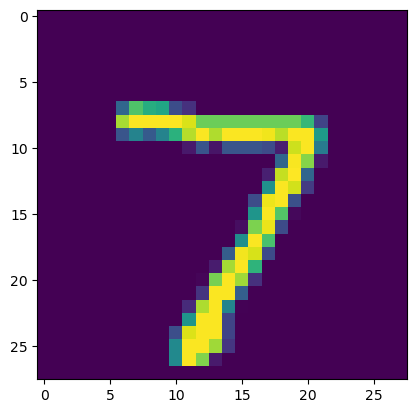

In [15]:
# 显示输入数据
show_image(x, idx=0)

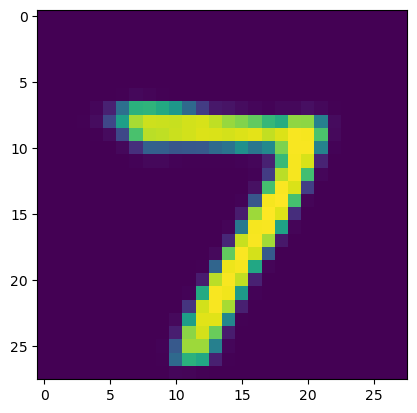

In [16]:
# 显示模型输出
show_image(x_hat, idx=0)

### Step 6. Generate image from noise vector

**Please note that this is not the correct generative process.**

* Even if we don't know exact p(z|x), we can generate images from noise, since the loss function of training VAE regulates the q(z|x) (simple and tractable posteriors) must close enough to N(0, I). If q(z|x) is close to N(0, I) "enough"(but not tightly close due to posterior collapse problem), N(0, I) may replace the encoder of VAE.

* To show this, I just tested with a noise vector sampled from N(0, I) similar with Generative Adversarial Network.

In [33]:
# 测测生成效果：直接从随机值产生一个图片
# Latent到底长啥样：https://taylordenouden.com/VAE-Latent-Space-Explorer/
# 注意没有encoder了
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

In [18]:
save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

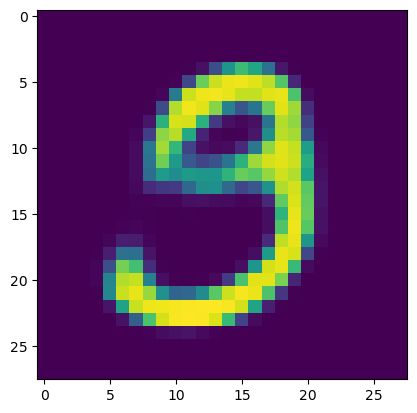

In [34]:
show_image(generated_images, idx=12)

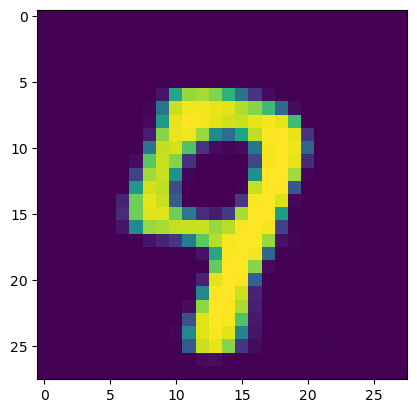

In [29]:
show_image(generated_images, idx=0)

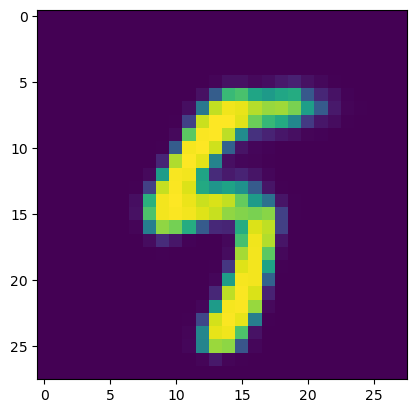

In [21]:
show_image(generated_images, idx=1)

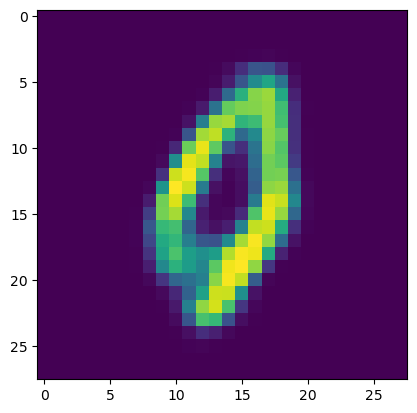

In [22]:
show_image(generated_images, idx=10)

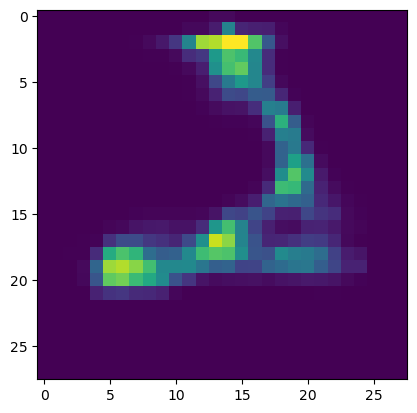

In [28]:
show_image(generated_images, idx=20)

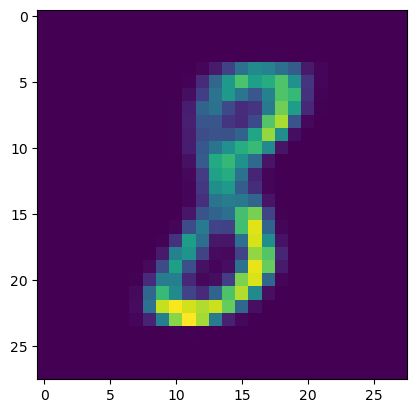

In [24]:
show_image(generated_images, idx=50)


解释VAE的一个Blog：https://www.jeremyjordan.me/variational-autoencoders/